In [23]:
import numpy as np
import math

def _absorb_all(freqy, temp, pres, vapor_pres, clw):
    """
    Function to compute the absorption coefficient for water vapor (H2O),
    oxygen (O2), and nitrogen (N2) using Phil Rosenkranz's code.

    Parameters:
    - freqy: Frequency [GHz]    
    - temp: Layer average temperature [K]
    - pres: Layer average pressure [mb]
    - vapor_pres: Layer average water vapor pressure [mb]
    - clw: Water in g/m**3

    Returns:
    - kabs_clear: Absorption coefficient [km^-1]

    Translated from Fortran77 into Python by Spencer Jones, CSU 02/24/2025
    """
    # Compute vapor density, rho [g/m^3]
    rho = vapor_pres * 100 * 18 / (8.314 * temp)

    # Calculate individual absorption coefficients
    kabs_H2O = abs_H2O(temp, pres, rho, freqy)
    kabs_O2 = abs_O2(temp, pres, rho, freqy)
    kabs_N2 = abs_N2(temp, pres, freqy)
    kabs_clw = absorb_clw(freqy, temp, clw)

    # Total absorption coefficient
    kabs_all = kabs_H2O + kabs_O2 + kabs_N2 + kabs_clw

    return kabs_all

absorb_all=np.vectorize(_absorb_all)

def abs_H2O(T, P, RHO, F):
    """
    Compute absorption coefficient in the atmosphere due to water vapor.

    Parameters:
    T : float
        Temperature in Kelvin
    P : float
        Pressure in millibar (0.1 to 1000)
    RHO : float
        Water vapor density in g/m^3
    F : float
        Frequency in GHz (0 to 800)

    Returns:
    ABH2O : float
        Absorption coefficient in Nepers/Km
    """

    # Line frequencies (GHz)
    FL = [
        22.2351, 183.3101, 321.2256, 325.1529, 380.1974, 439.1508,
        443.0183, 448.0011, 470.8890, 474.6891, 488.4911, 556.9360,
        620.7008, 752.0332, 916.1712
    ]

    # Line intensities at 300K
    S1 = [
        0.1314E-13, 0.2279E-11, 0.8058E-13, 0.2701E-11, 0.2444E-10,
        0.2185E-11, 0.4637E-12, 0.2568E-10, 0.8392E-12, 0.3272E-11, 0.6676E-12,
        0.1535E-08, 0.1711E-10, 0.1014E-08, 0.4238E-10
    ]

    # T coefficients of intensities
    B2 = [
        2.144, 0.668, 6.179, 1.541, 1.048, 3.595, 5.048, 1.405,
        3.597, 2.379, 2.852, 0.159, 2.391, 0.396, 1.441
    ]

    # Air-broadened width parameters at 300K
    W3 = [
        0.00281, 0.00287, 0.0023, 0.00278, 0.00287, 0.0021, 0.00186,
        0.00263, 0.00215, 0.00236, 0.0026, 0.00321, 0.00244, 0.00306, 0.00267
    ]

    # T-exponent of air-broadening
    X = [
        0.69, 0.64, 0.67, 0.68, 0.54, 0.63, 0.60, 0.66, 0.66, 0.65, 0.69, 0.69,
        0.71, 0.68, 0.70
    ]

    # Self-broadened width parameters at 300K
    WS = [
        0.01349, 0.01491, 0.0108, 0.0135, 0.01541, 0.0090, 0.00788,
        0.01275, 0.00983, 0.01095, 0.01313, 0.01320, 0.01140, 0.01253, 0.01275
    ]

    # T-exponent of self-broadening
    XS = [
        0.61, 0.85, 0.54, 0.74, 0.89, 0.52, 0.50, 0.67, 0.65, 0.64, 0.72,
        1.0, 0.68, 0.84, 0.78
    ]

    # Ratio of shift to width
    SR = [0., -0.017, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

    DF = [0.,0.]

    if RHO <= 0:
        return 0.0

    # Calculations
    PVAP = RHO * T / 217.0
    PDA = P - PVAP
    DEN = 3.335E16 * RHO  # const includes isotopic abundance
    TI = 300.0 / T
    TI2 = TI ** 2.5

    # Continuum terms
    CON = (5.43E-10 * PDA * TI**3 + 1.8E-8 * PVAP * TI**7.5) * PVAP * F**2

    # Add resonances
    SUM = 0.0
    for I in range(15):
        WIDTH = W3[I] * PDA * TI ** X[I] + WS[I] * PVAP * TI ** XS[I]
        SHIFT = SR[I] * WIDTH  # unknown temperature dependence
        WSQ = WIDTH ** 2
        S = S1[I] * TI2 * math.exp(B2[I] * (1.0 - TI))

        DF[0] = F - FL[I] - SHIFT
        DF[1] = F + FL[I] + SHIFT

        # Clough's definition of local line contribution
        BASE = WIDTH / (562500.0 + WSQ)

        # Do for positive and negative resonances
        RES = 0.0
        for J in range(2):
            if abs(DF[J]) < 750.:
              RES = RES + WIDTH / (DF[J]**2 + WSQ) - BASE

        SUM += S * RES * (F / FL[I]) ** 2

    ABH2O = 0.3183E-4 * DEN * SUM + CON
    return ABH2O



def abs_O2(TEMP, PRES, VAPDEN, FREQY):
    # Constants and coefficients
    F = np.array([118.7503, 56.2648, 62.4863, 58.4466, 60.3061, 59.5910, 59.1642, 60.4348,
                  58.3239, 61.1506, 57.6125, 61.8002, 56.9682, 62.4112, 56.3634, 62.9980,
                  55.7838, 63.5685, 55.2214, 64.1278, 54.6712, 64.6789, 54.1300, 65.2241,
                  53.5957, 65.7648, 53.0669, 66.3021, 52.5424, 66.8368, 52.0214, 67.3696,
                  51.5034, 67.9009, 368.4984, 424.7632, 487.2494, 715.3931, 773.8397, 834.1458])

    S300 = np.array([.2936E-14, .8079E-15, .2480E-14, .2228E-14, .3351E-14, .3292E-14, .3721E-14,
                     .3891E-14, .3640E-14, .4005E-14, .3227E-14, .3715E-14, .2627E-14, .3156E-14,
                     .1982E-14, .2477E-14, .1391E-14, .1808E-14, .9124E-15, .1230E-14, .5603E-15,
                     .7842E-15, .3228E-15, .4689E-15, .1748E-15, .2632E-15, .8898E-16, .1389E-15,
                     .4264E-16, .6899E-16, .1924E-16, .3229E-16, .8191E-17, .1423E-16, .6494E-15,
                     .7083E-14, .3025E-14, .1835E-14, .1158E-13, .3993E-14])

    BE = np.array([.009, .015, .083, .084, 0.212, 0.212, 0.391, 0.391, 0.626, 0.626, 0.915, 0.915,
                   1.260, 1.260, 1.660,
                   1.665, 2.119, 2.115, 2.624, 2.625, 3.194, 3.194, 3.814, 3.814, 4.484, 4.484,
                   5.224, 5.224, 6.004, 6.004,
                   6.844, 6.844, 7.744, 7.744, .048, .044, .049, .145, .141, .145])

    WB300 = 0.56
    X = 0.8
    W300 = np.array([1.67, 1.646, 1.468, 1.449, 1.382, 1.360, 1.319, 1.297, 1.266, 1.248, 1.221,
                     1.207, 1.181, 1.171, 1.144, 1.139, 1.110, 1.108, 1.079, 1.078, 1.05, 1.05, 1.02, 1.02,
                     1.00, 1.00, .97, .97, .94, .94, .92, .92, .89, .89, 1.64, 1.64, 1.64, 1.81, 1.81, 1.81])

    Y300 = np.array([-0.036, 0.2408, -0.3486, 0.5227, -0.5430, 0.5877, -0.3970, 0.3237, -0.1348,
                     0.0311, 0.0725, -0.1663, 0.2832, -0.3629, 0.3970, -0.4599, 0.4695, -0.5199,
                     0.5187, -0.5597, 0.5903, -0.6246, 0.6656, -0.6942, 0.7086, -0.7325, 0.7348,
                     -0.7546, 0.7702, -0.7864, 0.8083, -0.8210, 0.8439, -0.8529, 0., 0., 0., 0., 0., 0.])

    V = np.array([0.0079, -0.0978, 0.0844, -0.1273, 0.0699, -0.0776, 0.2309, -0.2825, 0.0436,
                  -0.0584, 0.6056, -0.6619, 0.6451, -0.6759, 0.6547, -0.6675, 0.6135, -0.6139,
                  0.2952, -0.2895, 0.2654, -0.2590, 0.3750, -0.3680, 0.5085, -0.5002, 0.6206,
                  -0.6091, 0.6526, -0.6393, 0.6640, -0.6475, 0.6729, -0.6545, 0., 0., 0., 0., 0., 0.])

    # Begin function calculation
    TH = 300. / TEMP
    TH1 = TH - 1.
    B = TH ** X
    PRESWV = VAPDEN * TEMP / 217.0
    PRESDA = PRES - PRESWV
    DEN = 0.001 * (PRESDA * B + 1.1 * PRESWV * TH)
    DENS = 0.001 * (PRESDA * TH ** 0.9 + 1.1 * PRESWV * TH)
    DFNR = WB300 * DEN
    SUM = 1.6e-17 * FREQY ** 2 * DFNR / (TH * (FREQY ** 2 + DFNR ** 2))

    # Loop over 40 line components
    for K in range(40):
        if K == 0:  # exception for 1- line
            DF = W300[0] * DENS
        else:
            DF = W300[K] * DEN

        FCEN = F[K]
        Y = 0.001 * PRES * B * (Y300[K] + V[K] * TH1)
        STR = S300[K] * np.exp(-BE[K] * TH1)
        SF1 = (DF + (FREQY - FCEN) * Y) / ((FREQY - FCEN) ** 2 + DF ** 2)
        SF2 = (DF - (FREQY + FCEN) * Y) / ((FREQY + FCEN) ** 2 + DF ** 2)
        SUM += STR * (SF1 + SF2) * (FREQY / F[K]) ** 2

    O2ABS = 0.5034e12 * SUM * PRESDA * TH ** 3 / np.pi
    O2ABS = max(O2ABS, 0.0)  # Ensure non-negative result
    return O2ABS


def abs_N2(temp, pres, freqy):
    """
    Function to calculate the nitrogen absorption coefficient (N2).

    Parameters:
    - temp: Temperature [K]
    - pres: Pressure [mb]
    - freqy: Frequency [GHz]

    Returns:
    - kabs_N2: Absorption coefficient for N2 [km^-1]
    """
    th = 300.0 / temp
    fdep = 0.5 + 0.5 / (1.0 + (freqy / 450.0) ** 2)
    bf = 6.5E-14 * fdep * pres ** 2 * freqy ** 2 * th ** 3.6
    absn2 = 1.29 * bf
    return absn2

def absorb_clw(freq, temp, water):
    '''
    Computes absorption in nepers/km by suspended water droplets
    Arguments (Input):
    Water in g/m**3
    freq in GHz (valid from 0 to 1000 GHz)
    Temp in Kelvin

    References:
    Liebe, Hufford and Manabe, Int. J. IR & MM Waves, V.12, pp. 659-675
       (1991); Liebe et al, AGARD Conf. Proc. 542, May 1993.

    Revision History:
        PWR 8/3/93 original version
        PWR 12/14/98 temp. dependence of EPS2 eliminated to agree
            with MPM93
        pwr 2/27/02 use exponential dep on T, eq. 2b instead of eq. 4a
        Translated from Fortran 77 to Python, Spencer Jones, 02/24/2025
    '''


    if water <= 0:
        kabs_clw = 0.
        return kabs_clw

    THETA1 = 1. - 300. / temp
    EPS0   = 77.66 - 103.3*THETA1
    EPS1   = 0.0671*EPS0
    EPS2   = 3.52
    FP     = 20.1*np.exp(7.88*THETA1)
    FS     = 39.8*FP
    EPS    = (EPS0-EPS1)/complex(1.,freq/FP) + (EPS1-EPS2)/complex(1.,freq/FS) + EPS2
    RE     = (EPS-1.)/(EPS+2.)
    kabs_clw = -0.06286*RE.imag*freq*water

    return kabs_clw



>    This project involves writing a radiative transfer code which considers emission of gases and cloud liquid water. The extinction coefficients are supplied by a subroutine available for microwave frequencies between 1 and 300 GHz.



>    A.	Using the subroutine “absorb.py” that will be mailed separately, compute the extinction coefficient as a function of frequency across the spectrum (1 – 300 GHz) for the surface layer of a standard US atmosphere. The standard atmosphere is provided at the end of this document.  Compare your results with those for the transmittance shown in the attached figure and discuss.



>    B.	Derive the relationship between radiances and brightness temperatures at the frequencies being considered. [Note: It is easier to work directly with brightness temperatures than radiances]



>    C.	Develop the radiative transfer code which considers extinction, emission, as well as reflection from the surface. Assume the emissivity of the surface to be 0.5 and that the surface is specular (i.e. the angle of the incident radiation is equal to the angle of the reflected radiation). This is a fairly good approximation over the ocean. Write the code so that the emissivity, the model atmosphere (including the number of layers), the surface temperature as well as the view angle are all parameters that can be modified by the user. The code should be written individually [i.e. no group efforts please].



>    D.	Develop a test procedure to verify that the code is producing the correct brightness temperatures with various assumptions. Explain the test procedure, the results you obtained, and how much confidence you have in the code based upon the test procedure.



>    E.	Compute the down- and upwelling brightness temperatures at the 183 GHz water vapor absorption line. Use the standard
atmosphere from (1), a surface temperature equal to the temperature of the bottom layer of the atmosphere and a view angle of 53° from nadir. [53° is the incidence angle of most current passive microwave sensors].



>    F.	Use the code developed above, at any one frequency or combination of frequencies, to investigate the relationship between a geophysical parameter (either cloud water or water vapor) and the brightness temperatures (either up- or downwelling). Be creative. The instructions are purposely vague.


| Height (km) | Pressure (mb) | T (K) | Density (g/m^3) | H20 (g/m^3) | O3 (g/m^3) |
|------------ | ------------- | ----- | --------------- | ----------- | ---------- |
|   0.0       | 1.013E+03     | 288.1 |     1.225E+03   |   5.9E+00   |  5.4E-05   |
|   1.0       | 8.986E+02     | 281.6 |     1.111E+03   |   4.2E+00   |  5.4E-05   |
|   2.0       | 7.950E+02     | 275.1 |     1.007E+03   |   2.9E+00   |  5.4E-05   |
|   3.0       | 7.012E+02     | 268.7 |     9.093E+02   |   1.8E+00   |  5.0E-05   |
|   4.0       | 6.166E+02     | 262.2 |     8.193E+02   |   1.1E+00   |  4.6E-05   |
|   5.0       | 5.405E+02     | 255.7 |     7.364E+02   |   6.4E-01   |  4.5E-05   |
|   6.0       | 4.722E+02     | 249.2 |     6.601E+02   |   3.8E-01   |  4.5E-05   |
|   7.0       | 4.111E+02     | 242.7 |     5.900E+02   |   2.1E-01   |  4.8E-05   |
|   8.0       | 3.565E+02     | 236.2 |     5.258E+02   |   1.2E-01   |  5.2E-05   |
|   9.0       | 3.080E+02     | 229.7 |     4.671E+02   |   4.6E-02   |  7.1E-05   |
|  10.0       | 2.650E+02     | 223.2 |     4.135E+02   |   1.8E-02   |  9.0E-05   |
|  11.0       | 2.270E+02     | 216.8 |     3.648E+02   |   8.2E-03   |  1.3E-04   |
|  12.0       | 1.940E+02     | 216.6 |     3.119E+02   |   3.7E-03   |  1.6E-04   |
|  13.0       | 1.658E+02     | 216.6 |     2.666E+02   |   1.8E-03   |  1.7E-04   |
|  14.0       | 1.417E+02     | 216.6 |     2.279E+02   |   8.4E-04   |  1.9E-04   |
|  15.0       | 1.211E+02     | 216.6 |     1.948E+02   |   7.2E-04   |  2.1E-04   |
|  16.0       | 1.035E+02     | 216.6 |     1.665E+02   |   6.1E-04   |  2.3E-04   |
|  17.0       | 8.850E+01     | 216.6 |     1.423E+02   |   5.2E-04   |  2.8E-04   |
|  18.0       | 7.565E+01     | 216.6 |     1.216E+02   |   4.4E-04   |  3.2E-04   |
|  19.0       | 6.467E+01     | 216.6 |     1.040E+02   |   4.4E-04   |  3.5E-04   |
|  20.0       | 5.529E+01     | 216.6 |     8.891E+01   |   4.4E-04   |  3.8E-04   |
|  21.0       | 4.729E+01     | 217.6 |     7.572E+01   |   4.8E-04   |  3.8E-04   |
|  22.0       | 4.047E+01     | 218.6 |     6.451E+01   |   5.2E-04   |  3.9E-04   |
|  23.0       | 3.467E+01     | 218.6 |     5.500E+01   |   5.7E-04   |  3.8E-04   |
|  24.0       | 2.972E+01     | 220.6 |     4.694E+01   |   6.1E-04   |  3.6E-04   |
|  25.0       | 2.549E+01     | 221.6 |     4.008E+01   |   6.6E-04   |  3.4E-04   |
|  30.0       | 1.197E+01     | 226.5 |     1.841E+01   |   3.8E-04   |  2.0E-04   |
|  35.0       | 5.746E+00     | 236.5 |     8.463E+00   |   1.6E-04   |  1.1E-04   |
|  40.0       | 2.871E+00     | 250.4 |     3.996E+00   |   6.7E-05   |  4.9E-05   |
|  45.0       | 1.491E+00     | 264.2 |     1.996E+00   |   3.2E-05   |  1.7E-05   |
|  50.0       | 7.978E-01     | 270.6 |     1.027E+00   |   1.2E-05   |  4.0E-06   |
|  75.0       | 5.520E-02     | 219.7 |     8.754E-02   |   1.5E-07   |  8.6E-08   |
| 100.0       | 3.008E-04     | 210.0 |     4.989E-04   |   1.0E-09   |  4.3E-11   |


>    A.	Using the subroutine “absorb.py” that will be mailed separately, compute the extinction coefficient as a function of frequency across the spectrum (1 – 300 GHz) for the surface layer of a standard US atmosphere. The standard atmosphere is provided at the end of this document.  Compare your results with those for the transmittance shown in the attached figure and discuss.

The extinction coefficient peaks correspond with valleys in the transmittance graph as these are inverse measurements of the same behavior. 
Howevwer, notably absent in the Extinction Coefficient graph is a peak at 2.45 GHz (the resonant frequency of water -- basis of household microwave functionality).


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

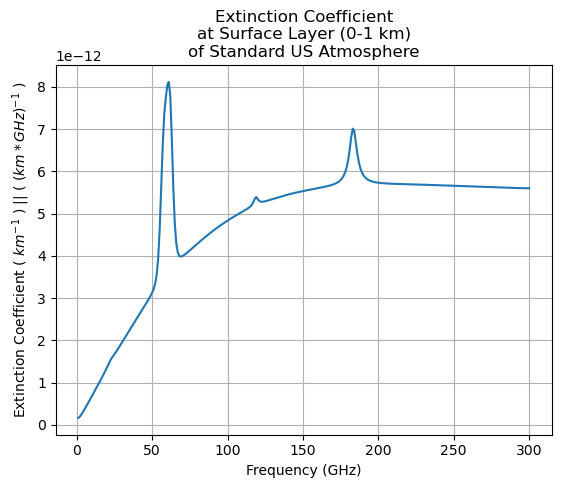

In [26]:
# def _absorb_all(freqy, temp, pres, vapor_pres, clw):
    # """
    # Function to compute the absorption coefficient for water vapor (H2O),
    # oxygen (O2), and nitrogen (N2) using Phil Rosenkranz's code.

    # Parameters:
    # - freqy: Frequency [GHz]    
    # - temp: Layer average temperature [K]
    # - pres: Layer average pressure [mb]
    # - vapor_pres: Layer average water vapor pressure [mb]
    # - clw: Water in g/m**3

    # Returns:
    # - kabs_clear: Absorption coefficient [km^-1]

    # Translated from Fortran77 into Python by Spencer Jones, CSU 02/24/2025
    # """
    # pass


vapor_pressure = (5.9E+00/1.225E+03) * 1.013E3
frequencies = range(1, 301)
# kabs = [_absorb_all(_freq, 288.1, 1.013E3, vapor_pressure, 5.9E+00) for _freq in frequencies]
kabs = [_absorb_all(_freq, 288.1, 1.013E3, vapor_pressure, 5.9E+00)/(4*np.pi*(_freq*1e9)) for _freq in frequencies]

kabs
plt.plot(frequencies, kabs)
plt.grid(True)
plt.title('Extinction Coefficient\nat Surface Layer (0-1 km)\nof Standard US Atmosphere')
plt.ylabel(r'Extinction Coefficient ( $km^{-1}$ ) || ( $\left(km*GHz\right)^{-1}$ )')
plt.xlabel(r'Frequency (GHz)')
plt.show()

>    B.	Derive the relationship between radiances and brightness temperatures at the frequencies being considered. [Note: It is easier to work directly with brightness temperatures than radiances]

>    C.	Develop the radiative transfer code which considers extinction, emission, as well as reflection from the surface. Assume the emissivity of the surface to be 0.5 and that the surface is specular (i.e. the angle of the incident radiation is equal to the angle of the reflected radiation). This is a fairly good approximation over the ocean. Write the code so that the emissivity, the model atmosphere (including the number of layers), the surface temperature as well as the view angle are all parameters that can be modified by the user. The code should be written individually [i.e. no group efforts please].

In [ ]:
def rte(emissivity, atmos_layers, surface_temp, view_angle):
    surface_emissivity=0.5

>    D.	Develop a test procedure to verify that the code is producing the correct brightness temperatures with various assumptions. Explain the test procedure, the results you obtained, and how much confidence you have in the code based upon the test procedure.

>    E.	Compute the down- and upwelling brightness temperatures at the 183 GHz water vapor absorption line. Use the standard
atmosphere from (1), a surface temperature equal to the temperature of the bottom layer of the atmosphere and a view angle of 53° from nadir. [53° is the incidence angle of most current passive microwave sensors].

>    F.	Use the code developed above, at any one frequency or combination of frequencies, to investigate the relationship between a geophysical parameter (either cloud water or water vapor) and the brightness temperatures (either up- or downwelling). Be creative. The instructions are purposely vague.